# Librerie

In [34]:
import pandas as pd
import numpy as np
import hexdump

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, BatchNormalization, MaxPooling2D,Dropout, Flatten

import sklearn as sk

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from PIL import Image

from glob import glob
from tqdm import tqdm

# Caricamento e descrizione del dataset

Caricamento del dataset [drowinessDetection](https://www.kaggle.com/code/tmleyncodes/drowsiness-detection) che contiene 2000 immagini di occhi aperti e 2000 immagini di occhi chiusi (in diverse condizioni di luce/angolazione, con/senza occhiali).

Le immagini sono ridimensionate a 10x10 così da rispettare i vincoli di memoria dei dispositivi (in particolare dell' ESP-8266).
Avviene inoltre il labeling delle immagini nel seguente modo:


*   1: occhi aperti
*   0: occhi chiusi

Le immagini sono poi normalizzate tramite il metodo min-max scaling.

Avviene successivamente la divisione train-test 80-20.



In [2]:
DIM = 10      # dimensione immagini 10x10

X_ORIG = []   # plot non fatto con immagine 10x10 ma con dimensione originale

X = []
Y = []

for i in tqdm(glob('dataset/Open_Eyes/*')):
    temp = np.array(Image.open(i).resize((DIM, DIM)))
    X.append(temp)
    Y.append(1)

    X_ORIG.append(np.array(Image.open(i)))
    
for i in tqdm(glob('dataset/Closed_Eyes/*')):
    temp = np.array(Image.open(i).resize((DIM, DIM)))
    X.append(temp)
    Y.append(0)

    X_ORIG.append(np.array(Image.open(i)))

100%|██████████| 2000/2000 [00:04<00:00, 400.01it/s]


In [3]:
# Normalizzazione con mix-max scaling: range tra il max e il min poi divido per 255
X = (np.array(X) - np.min(X)) / (np.max(X) - np.min(X))
X = X/255.0
Y = (np.array(Y) - np.min(Y)) / (np.max(Y) - np.min(Y))

# così va bene per la convoluzione
X = np.expand_dims(X,-1)

In [4]:
# split train-test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
x_train_orig, x_test_orig, y_train_orig, y_test_orig = train_test_split(X_ORIG, Y, test_size=0.2, random_state=42)

print("Num 1 in train: ", list(y_train).count(1))
print("Num 0 in train: ", list(y_train).count(0))
print("Num 1 in test : ", list(y_test).count(1))
print("Num 0 in test : ", list(y_test).count(0))

Num 1 in train:  1578
Num 0 in train:  1622
Num 1 in test :  422
Num 0 in test :  378


# Creazione NN

Si tratta di un problema di classificazione binaria che si pone l'obiettivo di capire se l'occhio rappresentato nell'immagine è aperto (classe 1) o chiuso (classe 0).  

Sono create 3 reti neurali convoluzionali in ordine di complessità.

Trattandosi di un problema di classificazione binaria, l'output layer ha una funzione di attivazione di tipo [sigmoide e la loss specificata per la compilazione è la crossentropy binaria](https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/)). L'algoritmo scelto è Adam.  

Il train avviene in 100 epoche con un batch size di 32.

In [5]:
models = {
    "small": Sequential([
        Conv2D(filters=1, kernel_size=(3,3), activation="relu", input_shape=(DIM, DIM, 1)),
        MaxPooling2D((2, 2)),

        Flatten(),     

        Dense(16, activation="relu"),
        Dense(units=1, activation="sigmoid")
    ]),
    "medium": Sequential([
        Conv2D(filters=8, kernel_size=(3,3), activation="relu", input_shape=(DIM, DIM, 1)),
        MaxPooling2D((2, 2)),

        Flatten(),     

        Dense(16, activation="relu"),
        Dense(units=1, activation="sigmoid")
    ]),
    "large": Sequential([
        Conv2D(filters=8, kernel_size=(3,3), activation="relu", input_shape=(DIM, DIM, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(filters=16, kernel_size=(2,2), activation="relu"),

        Flatten(),     

        Dense(16, activation="relu"),
        Dense(units=1, activation="sigmoid")
    ]),
}

In [6]:
# compilazione
models_history = {}
for name, model in models.items():
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    models_history[name] = model.fit(x_train, y_train, validation_split=0.2, epochs=100, batch_size=32)

Epoch 1/100
80/80 [==============================] - 2s 8ms/step - loss: 0.6932 - accuracy: 0.5043 - val_loss: 0.6929 - val_accuracy: 0.5172
Epoch 2/100
80/80 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5043 - val_loss: 0.6927 - val_accuracy: 0.5172
Epoch 3/100
80/80 [==============================] - 1s 11ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6924 - val_accuracy: 0.5172
Epoch 4/100
80/80 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.5043 - val_loss: 0.6921 - val_accuracy: 0.5172
Epoch 5/100
80/80 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5191 - val_loss: 0.6917 - val_accuracy: 0.5172
Epoch 6/100
80/80 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.5395 - val_loss: 0.6905 - val_accuracy: 0.5172
Epoch 7/100
80/80 [==============================] - 1s 10ms/step - loss: 0.6904 - accuracy: 0.5449 - val_loss: 0.6898 - val_accuracy: 0.6766
Epoch 8/100

# Valutazione NN

Di seguito avviene la valutazione sul test set della rete neurale creata. E' utilizzata solo la metrica accuracy in quanto le classi sono bilanciate. 

Sono riportate inoltre un insieme di immagini del test set valutate dal modello e confrontate con le label vere.

In [54]:
for name, model in models.items():
    loss, acc = model.evaluate(x_test, y_test)
    print("Accuracy "+name+" :"+str(acc))

25/25 [==============================] - 0s 4ms/step - loss: 0.2576 - accuracy: 0.9312
Accuracy small :0.9312499761581421
25/25 [==============================] - 0s 3ms/step - loss: 0.2576 - accuracy: 0.9362
Accuracy medium :0.9362499713897705
25/25 [==============================] - 0s 3ms/step - loss: 0.1116 - accuracy: 0.9638
Accuracy large :0.9637500047683716


25/25 [==============================] - 0s 4ms/step


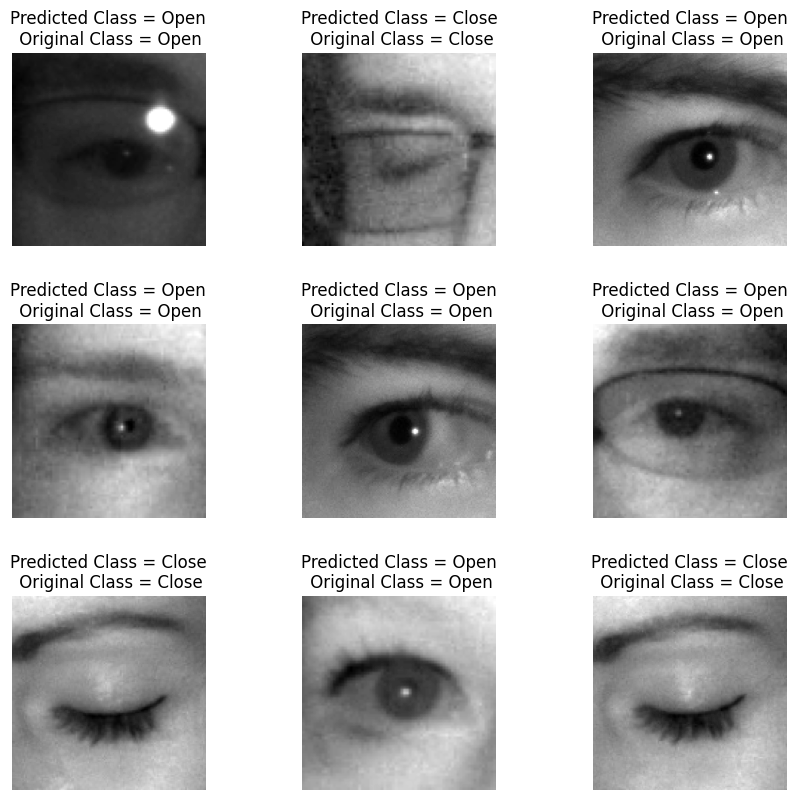

In [55]:
predicted_classes = models['large'].predict(x_test)

L = 3
W = 3
fig, axes = plt.subplots(L, W, figsize = (10, 10))
axes = axes.ravel()

for i in np.arange(0, (L * W)): 
    id_img = i + 50
    axes[i].imshow(x_test_orig[id_img], cmap='gray')
    true_val = "Close" if y_test[id_img] < 0.5 else "Open"
    pred_val = "Close" if predicted_classes[id_img] < 0.5 else "Open"
    axes[i].set_title("Predicted Class = "+pred_val+"\n Original Class = "+true_val)
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)

# Conversione

La conversione è fatta seguendo le [indicazioni ufficiali](https://www.tensorflow.org/lite/performance/post_training_quantization). Per il modello 'large' sono state fatte 2 conversioni una senza quantizzazione e l'altra con quantizzazione di tipo full-integer (anche dei tensori di input/output). 

Successivamente, il modello convertito è stato scritto come header C che poi sarà importato direttamente dal main (in PlatformIO o Arduino).  

All'interno di questo header inserisco anche l'input (che chiamo 'x') che verrà usato come test sulla scheda per simulare la predizione di un sample reale. L'input in questo caso è rappresentato dal sample di test con id 'id_img_to_test'. Il risultato della predizione che si ottiene sulle schede deve essere uguale a quello che si ottiene in questo notebook. 

Nell'header C inserisco anche altre due variabili interne 'input_size' e 'output_size' che indicano appunto le rispettive dimensioni di input e output.

Avviene poi la valutazione del modello quantizzato (necessario il supporto del relativo interprete) che sarà confrontata con quella del modello originale per vedere quanto ha inciso la quantizzazione.

In [47]:
"""
Converto il modello Tensorflow in un modello Tensoflow Lite.
E' possibile utilizzare la full-integer-quantization per ridurre la dimensione
del modello e diminuire il tempo di inferenza.

Per poterla usare, è necessario definire un dataset rappresentativo per poter definire
il range dei valori.

Link utile per creazione dataset rappresentativo : https://github.com/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/Custom_Image_Classification_EdgeTPU.ipynb

Params: 
  - model: modello Tensorflow da convertire
  - full_int_quantization: bool per decidere se usare quantizzazione o no
  - x_train: dataset di train usato per la creazione del dataset rappresentativo nel caso si voglia
             fare quantizzazione

Return: modello Tensorflow Lite
"""
def convert_to_tflite(model, full_int_quantization=False, x_train=None):
  converter = tf.lite.TFLiteConverter.from_keras_model(model)

  if (full_int_quantization):

    x_train_tflite = x_train.astype('float32') 

    def representative_dataset():
      for input_value in tf.data.Dataset.from_tensor_slices(x_train_tflite).batch(1).take(100):
        # Model has only one input so each data point has one element.
        yield [input_value]

    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
  else:
    converter.optimizations = []

  return converter.convert()

"""
Funzione per il salvataggio di un modello Tensorflow Lite come header C che verrà
importato nel sorgente C del microcontrollore.

E' possibile inserire anche la variabile da utilizzare come input per poter testare
la correttezza della previsione del modello.
E' possibile inserire anche la dimensione degli input/output.

Params:
  - file_name: nome del file in cui salvare l'header C
  - tflite_model: modello Tensorflow Lite
  - variable_name: nome della variabile che contiene i byte del modello
  - variables_to_append: stringhe aggiuntive inserite in coda che contengono ad
      esempio il valore dell'input da testare 
"""
def save_c_header(file_name, tflite_model, variable_name="model_data", variables_to_append=""):

  bytes = hexdump.dump(tflite_model).split(' ')
  c_array = ', '.join(['0x%02x' % int(byte, 16) for byte in bytes])
  c = 'const unsigned char %s[] DATA_ALIGN_ATTRIBUTE = {%s};' % (variable_name, c_array)
  c += '\nconst int %s_len = %d;' % (variable_name, len(bytes))
  preamble = '''
    // if having troubles with min/max, uncomment the following
    // #undef min    
    // #undef max
    #ifdef __has_attribute
    #define HAVE_ATTRIBUTE(x) __has_attribute(x)
    #else
    #define HAVE_ATTRIBUTE(x) 0
    #endif
    #if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
    #define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
    #else
    #define DATA_ALIGN_ATTRIBUTE
    #endif
    '''
  open(file_name+".h", "w").write(preamble + c + variables_to_append)

"""
Avviene la valutazione delle performance di un genercico modello Tensorflow Lite.

E' necessario eseguire il modello Tensorflow Lite tramite il relativo interprete
e poi valutare il risultato delle previsioni.

E' richiesto che i float siano a 32 bit.

Params:
  - x_test: x di test su cui valutare il modello
  - y_test: y true di test per la valutazione del modello
  - tflite_model: modello Tensorflow Lite da valutare
  - io_quantized: True se tensori di input o output hanno bisogno di essere quantizzati/dequantizzati
  - id_sample_to_test: id del sample nel train set da valutare

Return: dizionario {"Prediction value of test sample with ID ": val, "Accuracy": val: "Precision": val, "Recall": val}
"""
def tflite_model_evaluate(x_test, y_test, tflite_model, io_quantized=False, id_sample_to_test=0):

  x_test_tflite = x_test.astype('float32')

  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # quantizzo input per full-integer se serve
  if (io_quantized):
    input_scale, input_zero_point = input_details[0]["quantization"]
    x_test_tflite = x_test_tflite / input_scale + input_zero_point
    x_test_tflite = x_test_tflite.astype(input_details[0]["dtype"])

  y_pred = []

  for i in range(len(x_test_tflite)):
      
    interpreter.set_tensor(input_details[0]["index"], x_test_tflite[i:i+1])
    interpreter.invoke()
    #y_pred.append(0 if (interpreter.get_tensor(output_details[0]["index"])[0][0] < 0.5) else 1)
    y_pred.append(interpreter.get_tensor(output_details[0]["index"])[0][0])
    interpreter.reset_all_variables()

  # de-quantizzo output per full-integer se serve 
  if (io_quantized):
    y_pred = np.array(y_pred, dtype='float32')
    output_scale, output_zero_point = output_details[0]["quantization"]
    y_pred = (y_pred - output_zero_point) * output_scale

  y_pred_binary = [0 if (y < 0.5) else 1 for y in y_pred]

  acc = sk.metrics.accuracy_score(y_test, y_pred_binary)
  prec = sk.metrics.precision_score(y_test, y_pred_binary)
  rec = sk.metrics.recall_score(y_test, y_pred_binary)
  
  return {"Prediction value of test sample with ID "+str(id_sample_to_test): y_pred[id_sample_to_test], 
          "Accuracy": acc, "Precision": prec, "Recall": rec} 

"""
Funzione per printare il risultato della valutazione
"""
def print_evaluation(title, eval_dict):

  print(title)
  for k,v in eval_dict.items():
    print(k+": "+str(v))

In [52]:
# Definisco la variable che sarà testata nel dispositivo
id_img_to_test = 33
img_input = "\nfloat x["+str(DIM*DIM)+"] = {"
for id, pixel in enumerate (x_test[id_img_to_test].reshape(1, DIM*DIM)[0]):
  img_input = img_input + str(pixel)
  if ( not(id == (DIM*DIM)-1) ):         # mette la virgola a tutti tranne che l'ultimo
    img_input = img_input + ", "
  if ( (id != 0) and (id % 20 == 0) ):   # va a capo ogni 20 elementi
    img_input += "\n"
img_input += "};"
img_input = img_input + "const int input_size = "+str(DIM*DIM)+";\n"
img_input = img_input + "const int output_size = 1;"

for name, model in models.items():
  file_name = "c_headers/DrowsinessDetectionModel_"+name
  tflite_model = convert_to_tflite(model, full_int_quantization=False)
  save_c_header(file_name, tflite_model, variables_to_append=img_input)

  if (name.endswith("large")):
    file_name = "c_headers/DrowsinessDetectionModel_"+name+"_quant"
    tflite_model_quant = convert_to_tflite(model, full_int_quantization=True, x_train=x_train)
    save_c_header(file_name, tflite_model_quant, variables_to_append=img_input)  
    print_evaluation("TF model "+name+"_quant : ", tflite_model_evaluate(x_test, y_test, 
                                                                         tflite_model_quant, 
                                                                         id_sample_to_test=id_img_to_test, 
                                                                         io_quantized=True,))     

INFO:tensorflow:Assets written to: /var/folders/z3/yl30gjf55_x2qqgttnn1gjjc0000gn/T/tmp9lf08418/assets


INFO:tensorflow:Assets written to: /var/folders/z3/yl30gjf55_x2qqgttnn1gjjc0000gn/T/tmp9lf08418/assets
2023-06-01 09:46:32.848290: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-01 09:46:32.848341: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-06-01 09:46:32.849306: I tensorflow/cc/saved_model/reader.cc:52] Reading SavedModel from: /var/folders/z3/yl30gjf55_x2qqgttnn1gjjc0000gn/T/tmp9lf08418
2023-06-01 09:46:32.853060: I tensorflow/cc/saved_model/reader.cc:106] Reading meta graph with tags { serve }
2023-06-01 09:46:32.853091: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/z3/yl30gjf55_x2qqgttnn1gjjc0000gn/T/tmp9lf08418
2023-06-01 09:46:32.865699: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-06-01 09:46:32.952417: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

INFO:tensorflow:Assets written to: /var/folders/z3/yl30gjf55_x2qqgttnn1gjjc0000gn/T/tmpc1gr7x3u/assets


INFO:tensorflow:Assets written to: /var/folders/z3/yl30gjf55_x2qqgttnn1gjjc0000gn/T/tmpc1gr7x3u/assets
2023-06-01 09:46:35.187929: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-01 09:46:35.187952: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-06-01 09:46:35.188241: I tensorflow/cc/saved_model/reader.cc:52] Reading SavedModel from: /var/folders/z3/yl30gjf55_x2qqgttnn1gjjc0000gn/T/tmpc1gr7x3u
2023-06-01 09:46:35.189818: I tensorflow/cc/saved_model/reader.cc:106] Reading meta graph with tags { serve }
2023-06-01 09:46:35.189833: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/z3/yl30gjf55_x2qqgttnn1gjjc0000gn/T/tmpc1gr7x3u
2023-06-01 09:46:35.199773: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-06-01 09:46:35.274998: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

INFO:tensorflow:Assets written to: /var/folders/z3/yl30gjf55_x2qqgttnn1gjjc0000gn/T/tmpdwdinc7m/assets


INFO:tensorflow:Assets written to: /var/folders/z3/yl30gjf55_x2qqgttnn1gjjc0000gn/T/tmpdwdinc7m/assets
2023-06-01 09:46:37.089774: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-01 09:46:37.089808: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-06-01 09:46:37.090089: I tensorflow/cc/saved_model/reader.cc:52] Reading SavedModel from: /var/folders/z3/yl30gjf55_x2qqgttnn1gjjc0000gn/T/tmpdwdinc7m
2023-06-01 09:46:37.091999: I tensorflow/cc/saved_model/reader.cc:106] Reading meta graph with tags { serve }
2023-06-01 09:46:37.092017: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/z3/yl30gjf55_x2qqgttnn1gjjc0000gn/T/tmpdwdinc7m
2023-06-01 09:46:37.103387: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-06-01 09:46:37.197261: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

INFO:tensorflow:Assets written to: /var/folders/z3/yl30gjf55_x2qqgttnn1gjjc0000gn/T/tmpu27urusj/assets


INFO:tensorflow:Assets written to: /var/folders/z3/yl30gjf55_x2qqgttnn1gjjc0000gn/T/tmpu27urusj/assets


TF model large_quant : 
Prediction value of test sample with ID 33: 0.03515625
Accuracy: 0.96375
Precision: 0.9757869249394673
Recall: 0.9549763033175356


/Users/gabrielesavoia/.pyenv/versions/3.8.5/envs/env-uni-iot/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-06-01 09:46:39.056787: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-01 09:46:39.056809: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-06-01 09:46:39.057097: I tensorflow/cc/saved_model/reader.cc:52] Reading SavedModel from: /var/folders/z3/yl30gjf55_x2qqgttnn1gjjc0000gn/T/tmpu27urusj
2023-06-01 09:46:39.059101: I tensorflow/cc/saved_model/reader.cc:106] Reading meta graph with tags { serve }
2023-06-01 09:46:39.059121: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/z3/yl30gjf55_x2qqgttnn1gjjc0000gn/T/tmpu27urusj
2023-06-01 09:46:39.070971: I tensorflow/cc/saved_mo

Il risultato che ottengo nelle schede deve essere uguale a questo valore.

In [53]:
for name, model in models.items():
    res = model.predict( x_test[:id_img_to_test+1], verbose=0)
    res = res.reshape(1, id_img_to_test+1)[0]
    print(name+": "+str(res[id_img_to_test]))

small: 0.47000125
medium: 0.46196344
large: 0.034268122
